# Machine Learning Terapan - Anime Recommendation Dataset

- Nama: Yosua Samuel Edlyn Sinaga
- Email: yosuas282@gmail.com
- ID Dicoding: yosuasinaga

## Import Libraries

Menginstal library Surprise yang khusus digunakan untuk sistem rekomendasi dan mengimpor semua library yang dibutuhkan untuk analisis data, visualisasi, dan pembuatan model. Termasuk NumPy dan Pandas untuk manipulasi data, Matplotlib dan Seaborn untuk visualisasi, serta komponen dari Scikit-learn dan Surprise untuk pemodelan dan evaluasi.

In [5]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

## Load Data

Memuat dua dataset utama: dataset Anime `anime.csv` dan dataset Rating `ratings.csv` menggunakan pandas.

In [6]:
anime_df = pd.read_csv('dataset/anime.csv')
rating_df = pd.read_csv('dataset/rating.csv')

Dua DataFrame pandas telah dibuat dan siap untuk dianalisis: `anime_df` berisi informasi tentang anime dan `rating_df` berisi rating yang diberikan pengguna untuk anime.

## Exploratory Data Analysis (EDA)

### Dataset Anime

Ditampilkan 5 baris pertama dari dataset anime yang berisi kolom seperti ID Anime, Judul Anime, Genre, Tipe, Episode, Rating, dan Members.

In [7]:
# Melihat beberapa sampel data anime
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Menampilkan informasi tentang dataset anime termasuk jumlah total baris, nama kolom, jumlah nilai non-null, dan tipe data setiap kolom. Terlihat ada nilai null pada kolom `genre`, `type`, dan `rating`.

In [8]:
# Memeriksa informasi dataset anime
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153 entries, 0 to 11152
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  11153 non-null  int64  
 1   name      11153 non-null  object 
 2   genre     11091 non-null  object 
 3   type      11128 non-null  object 
 4   episodes  11153 non-null  object 
 5   rating    10931 non-null  float64
 6   members   11153 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 610.1+ KB


Menampilkan 10 genre teratas berdasarkan frekuensi kemunculan dalam dataset. Sebagian besar anime dalam dataset memiliki genre yang beragam, dengan genre Comedy menjadi yang paling dominan. Genre Comedy muncul sebanyak 523 kali, diikuti oleh genre Music dengan 301 kemunculan. Puncak frekuensi kemunculan genre terjadi pada genre Comedy, yang paling banyak muncul dalam dataset.

In [9]:
# Memeriksa nilai-nilai unik dan distribusi untuk genre
anime_df['genre'].value_counts().head(10)

genre
Comedy                   523
Music                    301
Kids                     199
Comedy, Slice of Life    179
Dementia                 137
Fantasy, Kids            128
Fantasy                  114
Comedy, Kids             112
Drama                    107
Drama, Kids              105
Name: count, dtype: int64

Mengidentifikasi 6 tipe anime teratas berdasarkan jumlah kemunculan dalam dataset. Tipe anime TV adalah yang paling banyak muncul, dengan total 3.787 kemunculan, diikuti oleh Movie dengan 2.340 kemunculan. Puncak frekuensi kemunculan tipe anime terjadi pada tipe TV, yang paling banyak tersedia dalam dataset.

In [10]:
# Top 6 tipe dengan jumlah anime terbanyak
anime_df['type'].value_counts().head(6)

type
TV         3787
Movie      2340
OVA        2199
Special    1657
ONA         657
Music       488
Name: count, dtype: int64

### Dataset Rating

Menampilkan 5 baris pertama dari dataset rating untuk memahami struktur datanya. Dataset rating berisi ID Pengguna, ID Anime, dan Rating.

In [11]:
# Melihat beberapa sampel data rating
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Memeriksa tipe data dan jumlah nilai non-null untuk setiap kolom dalam dataset rating. Tidak ada nilai null.

In [12]:
# Memeriksa informasi dataset rating
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7712252 entries, 0 to 7712251
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 176.5 MB


Menghitung frekuensi setiap nilai rating dan mengurutkannya berdasarkan nilai rating untuk melihat distribusi rating dalam dataset. Banyak pengguna yang belum memberikan rating pada anime, yang ditandai dengan nilai rating -1 sebanyak 1.445.887 entri. Setelah nilai -1, rating terbanyak berada di rentang 7, 8, dan 10, yang menunjukkan kecenderungan pengguna memberikan rating tinggi. Rating rendah (1–3) sangat jarang, yang menandakan adanya bias positif dalam penilaian anime atau kemungkinan pengguna cenderung tidak memberi rating jika mereka tidak menyukai anime.

In [13]:
# Distribusi rating
rating_df['rating'].value_counts().sort_index()

rating
-1     1445887
 1       14728
 2       21728
 3       39601
 4      100641
 5      273986
 6      624450
 7     1358273
 8     1634495
 9     1248277
 10     950186
Name: count, dtype: int64

### Distribusi Rating per Pengguna

Mayoritas pengguna hanya memberikan sedikit rating. Sebagian besar pengguna hanya memberi rating untuk kurang dari 5 anime. Distribusi sangat miring ke kanan (right-skewed), sebagian kecil pengguna sangat aktif dan memberi puluhan hingga ratusan rating.

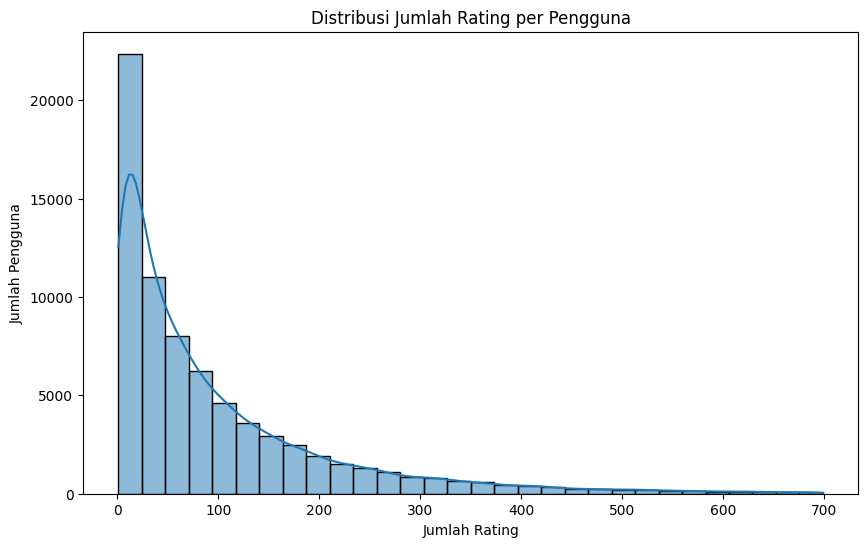

In [14]:
# Menghitung jumlah rating per pengguna
ratings_per_user = rating_df.groupby('user_id')['rating'].count().reset_index()
ratings_per_user.columns = ['user_id', 'rating_count']

# Visualisasi distribusi jumlah rating per pengguna
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user[ratings_per_user['rating_count'] < 700]['rating_count'], bins=30, kde=True)
plt.title('Distribusi Jumlah Rating per Pengguna')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Pengguna')
plt.show()

### Distribusi Rating per Anime

Sebagian besar anime menerima sangat sedikit rating, lonjakan tertinggi pada 1–5 rating per anime. Hanya sedikit anime yang mendapatkan puluhan hingga ratusan atau ribuan rating. Banyak anime yang cold items dengan hampir tak ada feedback, sementara segelintir anime populer mengumpulkan sebagian besar rating.

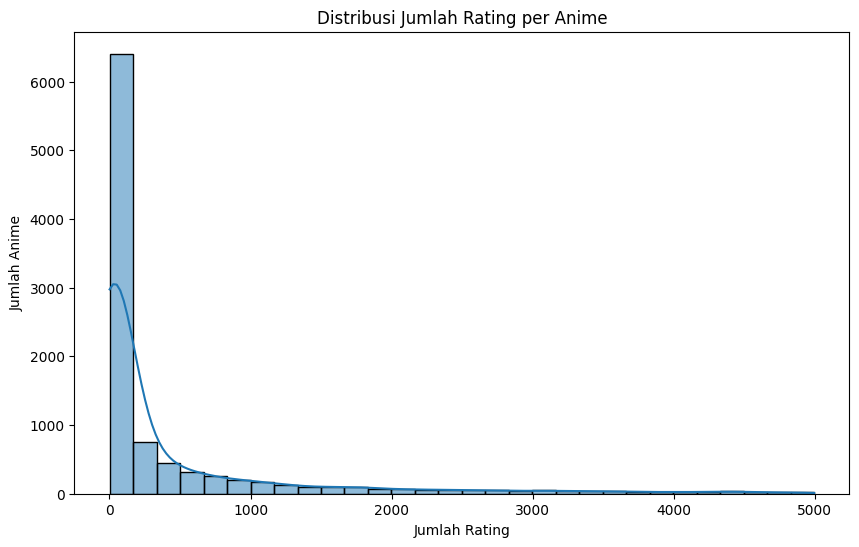

In [15]:
# Menghitung jumlah rating per anime
ratings_per_anime = rating_df.groupby('anime_id')['rating'].count().reset_index()
ratings_per_anime.columns = ['anime_id', 'rating_count']

# Visualisasi distribusi jumlah rating per anime
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_anime[ratings_per_anime['rating_count'] < 5000]['rating_count'], bins=30, kde=True)
plt.title('Distribusi Jumlah Rating per Anime')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Anime')
plt.show()

### Cek Missing Values

Memeriksa jumlah nilai yang hilang (missing values) pada setiap kolom dalam ketiga dataset.
1. Dataset Anime:
- anime_id: Tidak ada nilai yang hilang.
- name: Tidak ada nilai yang hilang.
- genre: 62 nilai yang hilang.
- type: 25 nilai yang hilang.
- episodes: Tidak ada nilai yang hilang.
- rating: 222 nilai yang hilang.
- members: Tidak ada nilai yang hilang.

2. Dataset Rating:
- user_id: Tidak ada nilai yang hilang.
- anime_id: Tidak ada nilai yang hilang.
- rating: Tidak ada nilai yang hilang.

In [16]:
# Memeriksa missing values pada setiap dataset
print("Missing values in Anime dataset:")
print(anime_df.isnull().sum())

print("\nMissing values in Rating dataset:")
print(rating_df.isnull().sum())

Missing values in Anime dataset:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      222
members       0
dtype: int64

Missing values in Rating dataset:
user_id     0
anime_id    0
rating      0
dtype: int64


## Data Preprocessing

### Penanganan Missing Values

Menghapus baris dengan nilai yang hilang pada kolom **genre**, **type**, dan **rating** dari dataset anime. Karena dataset pengguna tidak ada, tidak ada penanganan missing values pada kolom **Age**.


In [17]:
# Menangani missing values pada dataset Anime
anime_df = anime_df.dropna(subset=['genre', 'type', 'rating'])

# Dataset Rating tidak memiliki missing values, jadi tidak perlu penanganan lebih lanjut


### Memproses dataset Rating 

Dataset asli memiliki lebih dari **6 juta** entri setelah menghapus data dengan **rating -1**. Namun, karena dataset yang sangat besar, proses komputasi bisa menjadi sangat lambat. Oleh karena itu, untuk efisiensi pemrosesan, dataset dipangkas menjadi **1.3 juta** entri dengan mengambil **sampel acak**. Detailnya adalah sebagai berikut:
- **Penghapusan Rating -1** mengurangi ukuran dataset dari 7 juta entri menjadi sekitar 6.2 juta entri.
- **Sampling acak** menghasilkan dataset berukuran 1.3 juta entri, yang lebih efisien untuk pemrosesan lebih lanjut.
- **Pencocokan `anime_id`** memastikan bahwa tidak ada **`anime_id`** yang hilang di antara dua dataset (rating dan anime).


In [18]:
# Menghapus semua baris dengan rating -1
rating_df = rating_df[rating_df['rating'] != -1]

# Cek jumlah baris setelah penghapusan
print(f"Jumlah entri setelah menghapus rating -1: {rating_df.shape[0]}")
# Ambil sampel acak sebanyak 1.1 juta entri
rating_df = rating_df.sample(n=1336445, random_state=42)
# Cek jumlah baris setelah sampling
print(f"Jumlah entri setelah sampling: {rating_df.shape[0]}")

# Pastikan `rating_df` berisi semua `anime_id` yang valid
valid_anime_ids = set(rating_df['anime_id'].tolist())
# Hapus data pada anime_df yang tidak ada di valid_anime_ids
anime_df = anime_df[anime_df['anime_id'].isin(valid_anime_ids)]
# Cek jumlah entri setelah filter
print(f"Jumlah entri setelah mencocokkan anime_id: {anime_df.shape[0]}")

# Pastikan `anime_df` berisi semua `anime_id` yang valid
valid_anime_ids = set(anime_df['anime_id'].tolist())
# Hapus data pada rating_df yang tidak ada di valid_anime_ids
rating_df = rating_df[rating_df['anime_id'].isin(valid_anime_ids)]
# Cek jumlah entri setelah filter
print(f"Jumlah entri setelah mencocokkan anime_id: {rating_df.shape[0]}")

# Anime yang ada di anime_df tetapi tidak ada di rating_df
missing_in_ratings = set(anime_df['anime_id']) - set(rating_df['anime_id'])
print(f"Jumlah anime_id yang ada di anime_df tetapi tidak ada di rating_df: {len(missing_in_ratings)}")

# Anime yang ada di rating_df tetapi tidak ada di anime_df
missing_in_anime_df = set(rating_df['anime_id']) - set(anime_df['anime_id'])
print(f"Jumlah anime_id yang ada di rating_df tetapi tidak ada di anime_df: {len(missing_in_anime_df)}")


Jumlah entri setelah menghapus rating -1: 6266365
Jumlah entri setelah sampling: 1336445
Jumlah entri setelah mencocokkan anime_id: 7512
Jumlah entri setelah mencocokkan anime_id: 1336418
Jumlah anime_id yang ada di anime_df tetapi tidak ada di rating_df: 0
Jumlah anime_id yang ada di rating_df tetapi tidak ada di anime_df: 0


- **`reset_index(drop=True)`** digunakan untuk mereset index dan menghapus kolom index lama.
- Dataset akan memiliki index yang dimulai dari **0** dan berlanjut secara berturut-turut hingga baris terakhir.

In [19]:
# Reset index sehingga index dimulai dari 0
rating_df = rating_df.reset_index(drop=True)

# Cek hasil setelah reset index
rating_df.head()


,user_id,anime_id,rating
0,72341,10087,8
1,2771,6351,9
2,36317,22199,9
3,75,3927,8
4,56810,240,8


- **`reset_index(drop=True)`** digunakan untuk mereset index dan menghapus kolom index lama.
- Dataset akan memiliki index yang dimulai dari **0** dan berlanjut secara berturut-turut hingga baris terakhir.

In [20]:
# Reset index sehingga index dimulai dari 0
anime_df = anime_df.reset_index(drop=True)

# Cek hasil setelah reset index
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


### Filtering Data

Mengkonversi **episodes** ke tipe numerik dan menangani nilai tidak valid dengan coercion. Memfilter anime berdasarkan jumlah episode yang masuk akal (misalnya, lebih dari 0 episode).

In [21]:
# Konversi 'episodes' ke numerik dan tangani nilai tidak valid
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')

# Filter anime dengan jumlah episode yang masuk akal (misalnya lebih dari 0 episode)
anime_df = anime_df[anime_df['episodes'] > 0]

Memfilter **rating** hanya yang eksplisit (nilai > 0) dalam dataset **Rating**.

In [22]:
# Filter rating eksplisit (nilai > 0)
explicit_ratings = rating_df[rating_df['rating'] > 0]

Menghitung jumlah rating per pengguna dan per anime. Memfilter dataset untuk hanya menyertakan pengguna yang memberikan minimal 5 rating dan anime yang menerima minimal 5 rating.

In [23]:
# Hitung jumlah rating per pengguna dan per anime
user_counts = explicit_ratings['user_id'].value_counts()
anime_counts = explicit_ratings['anime_id'].value_counts()

# Filter pengguna dan anime yang memiliki minimal 5 interaksi
min_user_ratings = 5
min_anime_ratings = 5

user_filtered = user_counts[user_counts >= min_user_ratings].index
anime_filtered = anime_counts[anime_counts >= min_anime_ratings].index

# Filter dataset berdasarkan pengguna dan anime yang sudah difilter
filtered_ratings = explicit_ratings[
    explicit_ratings['user_id'].isin(user_filtered) &
    explicit_ratings['anime_id'].isin(anime_filtered)
]

### Mapping ID

Membuat mapping antara **user_id** dan **anime_id** dengan indeks numerik (0, 1, 2, ...) untuk mempermudah pembuatan matriks dan komputasi dalam model. Juga membuat mapping sebaliknya untuk konversi kembali dari indeks ke ID asli.

In [24]:
# Buat mapping untuk user_id dan anime_id
user_to_idx = {user: idx for idx, user in enumerate(filtered_ratings['user_id'].unique())}
anime_to_idx = {anime: idx for idx, anime in enumerate(filtered_ratings['anime_id'].unique())}

# Buat mapping sebaliknya untuk konversi balik
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_anime = {idx: anime for anime, idx in anime_to_idx.items()}

# Konversi user_id dan anime_id ke indeks
filtered_ratings['user_idx'] = filtered_ratings['user_id'].map(user_to_idx)
filtered_ratings['anime_idx'] = filtered_ratings['anime_id'].map(anime_to_idx)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25272\3311408048.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['user_idx'] = filtered_ratings['user_id'].map(user_to_idx)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25272\3311408048.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['anime_idx'] = filtered_ratings['anime_id'].map(anime_to_idx)


### Splitting Data

Membagi dataset **rating** yang sudah difilter menjadi data training (80%) dan testing (20%) menggunakan stratified sampling berdasarkan nilai **rating** untuk memastikan distribusi rating dalam data training dan testing tetap konsisten.

In [25]:
# Split data menjadi training dan testing
train_data, test_data = train_test_split(
    filtered_ratings,
    test_size=0.2,
    random_state=42,
    stratify=filtered_ratings['rating']  # Stratify berdasarkan nilai rating
)

### Normalisasi Rating

Menormalisasi rating dengan mengurangkan rata-rata rating pengguna dari setiap rating yang diberikan. Hal ini membantu mengatasi bias pengguna, seperti pengguna yang cenderung memberikan rating tinggi atau rendah secara konsisten.

In [26]:
# Hitung rata-rata rating per pengguna
user_mean = train_data.groupby('user_idx')['rating'].mean()

# Fungsi untuk normalisasi
def normalize_ratings(df):
    df_copy = df.copy()
    for user in df_copy['user_idx'].unique():
        if user in user_mean:
            user_mask = df_copy['user_idx'] == user
            df_copy.loc[user_mask, 'normalized_rating'] = df_copy.loc[user_mask, 'rating'] - user_mean[user]
    return df_copy

# Normalisasi data training dan testing
train_data = normalize_ratings(train_data)
test_data = normalize_ratings(test_data)


## Modelling and Result

### Pre-komputasi Matriks untuk Efisiensi

Melakukan pre-komputasi matriks **user-item**, matriks kesamaan antar pengguna, dan matriks kesamaan antar anime untuk meningkatkan efisiensi ketika melakukan prediksi. Hal ini untuk menghindari perhitungan matriks berulang kali setiap kali fungsi rekomendasi dipanggil.

In [27]:
# Pre-compute the user-item matrix once for efficiency
def build_user_item_matrix():
    # Create user-item matrix from training data
    user_item_matrix = pd.pivot_table(
        train_data,
        values='rating',
        index='user_idx',
        columns='anime_idx',
        fill_value=0
    )
    return user_item_matrix

# Build the matrix
user_item_matrix = build_user_item_matrix()

# Calculate user similarity once
user_similarity = cosine_similarity(user_item_matrix)

# Get item-item similarity matrix
item_user_matrix = user_item_matrix.T
item_similarity = cosine_similarity(item_user_matrix)

### User-based Collaborative Filtering

Kita membuat fungsi untuk menghasilkan rekomendasi anime menggunakan metode **User-based Collaborative Filtering**. Fungsi ini bekerja dengan terlebih dahulu memvalidasi keberadaan user ID dalam dataset dan menampilkan anime-anime dengan rating tertinggi dari pengguna tersebut sebagai gambaran preferensi. Setelah itu, fungsi akan menghitung **similarity score** antara pengguna target dengan semua pengguna lain dalam sistem menggunakan matriks **user-item** yang telah dibuat sebelumnya. Untuk setiap anime yang belum pernah diberi rating oleh pengguna target, fungsi akan memprediksi rating dengan menghitung **weighted average** dari rating yang diberikan pengguna-pengguna serupa, di mana bobot ditentukan berdasarkan tingkat kesamaan antar pengguna. Hasil prediksi kemudian diurutkan berdasarkan rating tertinggi dan fungsi akan mengembalikan N rekomendasi teratas sesuai dengan parameter yang telah ditentukan.Kita membuat fungsi untuk menghasilkan rekomendasi anime menggunakan metode **User-based Collaborative Filtering**. Fungsi ini bekerja dengan terlebih dahulu memvalidasi keberadaan user ID dalam dataset dan menampilkan anime-anime dengan rating tertinggi dari pengguna tersebut sebagai gambaran preferensi. Setelah itu, fungsi akan menghitung **similarity score** antara pengguna target dengan semua pengguna lain dalam sistem menggunakan matriks **user-item** yang telah dibuat sebelumnya. Untuk setiap anime yang belum pernah diberi rating oleh pengguna target, fungsi akan memprediksi rating dengan menghitung **weighted average** dari rating yang diberikan pengguna-pengguna serupa, di mana bobot ditentukan berdasarkan tingkat kesamaan antar pengguna. Hasil prediksi kemudian diurutkan berdasarkan rating tertinggi dan fungsi akan mengembalikan N rekomendasi teratas sesuai dengan parameter yang telah ditentukan.


In [28]:
def get_user_based_recommendations(user_id, n_recommendations=10):
    # Cek apakah user_id ada dalam dataset
    if user_id not in user_to_idx:
        print(f"User ID {user_id} tidak ditemukan dalam dataset.")
        return None

    user_idx = user_to_idx[user_id]

    # Ambil anime-anime yang sudah diberi rating oleh user
    user_rated_anime = filtered_ratings[filtered_ratings['user_id'] == user_id]

    # Tampilkan anime-anime dengan rating tinggi dari user
    print(f'Menampilkan rekomendasi User-based CF untuk user: {user_id}\n')
    print('===' * 13)
    print('Anime dengan rating tinggi dari pengguna')
    print('----' * 10)

    # Ambil 5 anime teratas yang diberi rating tertinggi oleh user
    top_anime_by_user = (
        user_rated_anime.sort_values(
            by='rating',
            ascending=False
        )
        .head(5)
    )

    # Ambil detail anime berdasarkan anime_id
    top_rated_anime_ids = top_anime_by_user['anime_id'].values
    top_rated_anime = anime_df[anime_df['anime_id'].isin(top_rated_anime_ids)]

    # Tampilkan informasi anime-anime dengan rating tertinggi
    for _, row in top_rated_anime.iterrows():
        print(f"{row['name']} : Rating {top_anime_by_user[top_anime_by_user['anime_id'] == row['anime_id']]['rating'].values[0]}")

    print('\n')
    print('----' * 7)
    print(f'{n_recommendations} Rekomendasi Anime Teratas (User-based CF)')
    print('----' * 7)

    # Buat user-item matrix dari data training
    user_item_matrix = pd.pivot_table(
        train_data,
        values='rating',
        index='user_idx',
        columns='anime_idx',
        fill_value=0
    )

    # Hitung similarity antar user (cosine similarity)
    user_similarity = cosine_similarity(user_item_matrix)

    # Dapatkan similarity score pengguna target dengan semua pengguna lain
    user_sim_scores = user_similarity[user_idx]

    # Filter anime yang sudah diberi rating oleh pengguna target
    rated_items = user_rated_anime['anime_id'].tolist()

    # Dapatkan prediksi rating untuk semua anime yang belum diberi rating
    predicted_ratings = {}

    for anime_idx in range(len(anime_to_idx)):
        if anime_idx not in rated_items:
            # Dapatkan rating dari semua pengguna untuk anime ini
            item_ratings = user_item_matrix.iloc[:, anime_idx]

            # Hitung weighted rating berdasarkan user similarity
            numerator = np.sum(item_ratings * user_sim_scores)
            denominator = np.sum(np.abs(user_sim_scores) * (item_ratings != 0))

            if denominator != 0:
                predicted_ratings[anime_idx] = numerator / denominator

    # Sorting berdasarkan predicted rating
    sorted_predictions = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)

    # Ambil top N rekomendasi
    top_n_items = [idx_to_anime[item[0]] for item in sorted_predictions[:n_recommendations]]

    # Dapatkan informasi anime
    recommended_anime = anime_df[anime_df['anime_id'].isin(top_n_items)]

    # Tampilkan daftar anime rekomendasi
    for _, row in recommended_anime.iterrows():
        print(f"{row['name']}")

    return recommended_anime[['anime_id', 'name', 'genre']]


### Item-based Collaborative Filtering

Kita membuat fungsi untuk menghasilkan rekomendasi anime menggunakan metode **Item-based Collaborative Filtering**. Fungsi ini dimulai dengan memvalidasi keberadaan **user ID** dalam dataset dan menampilkan anime-anime dengan rating tertinggi dari pengguna tersebut untuk memberikan gambaran tentang preferensi pengguna. Berbeda dengan **user-based CF**, metode ini berfokus pada kesamaan antar item atau anime. Fungsi akan mengidentifikasi anime-anime yang telah diberi rating oleh pengguna target, kemudian untuk setiap anime yang belum pernah diberi rating, sistem akan menghitung prediksi rating berdasarkan kesamaan dengan anime-anime yang sudah pernah dirating sebelumnya. Perhitungan dilakukan dengan menggunakan **weighted average** dari rating yang telah diberikan pengguna pada anime-anime serupa, di mana bobot ditentukan oleh tingkat kesamaan antar anime menggunakan matriks similarity yang telah dihitung sebelumnya. Hasil prediksi kemudian diurutkan berdasarkan nilai tertinggi dan fungsi akan mengembalikan N rekomendasi anime teratas sesuai parameter yang ditentukan.

In [29]:
def get_item_based_recommendations(user_id, n=10):
    # Cek apakah user_id ada di dalam dataset
    if user_id not in user_to_idx:
        print(f"User ID {user_id} tidak ditemukan dalam dataset.")
        return None

    user_idx = user_to_idx[user_id]

    # Ambil anime-anime yang sudah diberi rating oleh user
    user_rated_anime = filtered_ratings[filtered_ratings['user_id'] == user_id]

    # Tampilkan anime-anime dengan rating tinggi dari user
    print(f'Menampilkan rekomendasi Item-based CF untuk user: {user_id}\n')
    print('===' * 13)
    print('Anime dengan rating tinggi dari pengguna')
    print('----' * 10)

    # Ambil 5 anime teratas yang diberi rating tertinggi oleh user
    top_anime_by_user = (
        user_rated_anime.sort_values(
            by='rating',
            ascending=False
        )
        .head(5)
    )

    # Ambil detail anime berdasarkan anime_id
    top_rated_anime_ids = top_anime_by_user['anime_id'].values
    top_rated_anime = anime_df[anime_df['anime_id'].isin(top_rated_anime_ids)]

    # Tampilkan informasi anime-anime dengan rating tertinggi
    for _, row in top_rated_anime.iterrows():
        print(f"{row['name']} : Rating {top_anime_by_user[top_anime_by_user['anime_id'] == row['anime_id']]['rating'].values[0]}")

    print('\n')
    print('----' * 7)
    print(f'{n} Rekomendasi Anime Teratas (Item-based CF)')
    print('----' * 7)

    # Dapatkan anime yang telah dirating oleh pengguna target
    user_ratings = filtered_ratings[filtered_ratings['user_id'] == user_idx]

    # Hitung skor prediksi untuk semua anime yang belum dirating
    all_items = set(range(len(anime_to_idx)))
    rated_items = set(user_ratings['anime_id'].tolist())
    unrated_items = all_items - rated_items

    predictions = {}
    for item_idx in unrated_items:
        if item_idx in item_user_matrix.index:
            weighted_sum = 0
            similarity_sum = 0

            for _, row in user_ratings.iterrows():
                rated_item_idx = row['anime_id']
                rating = row['rating']

                if rated_item_idx in item_user_matrix.index:
                    # Get position dalam similarity matrix
                    item_pos = item_user_matrix.index.get_loc(item_idx)
                    rated_item_pos = item_user_matrix.index.get_loc(rated_item_idx)

                    # Similarity antara anime yang belum dirating dengan anime yang sudah dirating
                    sim = item_similarity[item_pos, rated_item_pos]

                    weighted_sum += sim * rating
                    similarity_sum += abs(sim)

            if similarity_sum > 0:
                predictions[item_idx] = weighted_sum / similarity_sum

    # Sorting prediksi
    sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)

    # Ambil top N rekomendasi
    top_n_items = [idx_to_anime[item[0]] for item in sorted_predictions[:n]]

    # Dapatkan informasi anime
    recommended_anime = anime_df[anime_df['anime_id'].isin(top_n_items)]

    # Tampilkan daftar anime rekomendasi
    for _, row in recommended_anime.iterrows():
        print(f"{row['name']}")

    return recommended_anime[['anime_id', 'name', 'genre']]


### Matrix Factorization dengan SVD

Implementasi pendekatan **Matrix Factorization** menggunakan algoritma **SVD (Singular Value Decomposition)** dengan mengkonversi data rating ke format yang dapat diproses oleh library **Surprise**, membagi data menjadi training dan testing set, melatih model SVD dengan 100 faktor laten selama 20 epoch, dan membuat fungsi untuk mendapatkan rekomendasi menggunakan model SVD terlatih.

In [37]:
# Konversi data ke format yang dapat digunakan oleh Surprise
reader = Reader(rating_scale=(0, 10))  # Skala rating 0 hingga 10
data = Dataset.load_from_df(filtered_ratings[['user_idx', 'anime_idx', 'rating']], reader)

# Split data
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# Training model SVD
svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd_model.fit(trainset)

# Fungsi untuk mendapatkan rekomendasi menggunakan SVD
def svd_recommendations(user_id, n_recommendations=10):
    # Konversi user_id ke user_idx
    if user_id not in user_to_idx:
        return "User tidak ditemukan dalam dataset"

    user_idx = user_to_idx[user_id]

    # Dapatkan item yang telah dirating oleh pengguna
    rated_items = set(train_data[train_data['user_idx'] == user_idx]['anime_idx'].tolist())

    # Semua item yang tersedia
    all_items = set(anime_to_idx.values())

    # Item yang belum dirating
    unrated_items = all_items - rated_items

    # Prediksi rating untuk item yang belum dirating
    predictions = [(item_idx, svd_model.predict(user_idx, item_idx).est)
                for item_idx in unrated_items]

    # Sorting prediksi
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Ambil top N rekomendasi
    top_n_items = [idx_to_anime[item[0]] for item in predictions[:n_recommendations]]

    # Dapatkan informasi anime
    recommended_anime = anime_df[anime_df['anime_id'].isin(top_n_items)]

    return recommended_anime[['anime_id', 'name', 'genre']]


### SVD

Kita membuat fungsi untuk menghasilkan rekomendasi anime menggunakan model SVD yang telah terbukti optimal. Fungsi ini bekerja dengan terlebih dahulu mengecek validitas user ID dalam dataset, kemudian menampilkan anime-anime dengan rating tertinggi dari pengguna tersebut sebagai referensi preferensi. Setelah itu, fungsi akan mengidentifikasi anime-anime yang belum diberi rating oleh pengguna dan memprediksi rating untuk anime-anime tersebut menggunakan model SVD. Pada tahap akhir, hasil prediksi akan diurutkan berdasarkan rating tertinggi dan mengembalikan N rekomendasi teratas sesuai dengan parameter yang ditentukan.

In [38]:
def get_top_anime_recommendations(user_id, n=10):
    # Cek apakah user_id ada di dalam dataset
    if user_id not in user_to_idx:
        print(f"User ID {user_id} tidak ditemukan dalam dataset.")
        return None

    user_idx = user_to_idx[user_id]

    # Ambil anime-anime yang sudah diberi rating oleh user
    user_rated_anime = filtered_ratings[filtered_ratings['user_id'] == user_id]

    # Tampilkan anime-anime dengan rating tinggi dari user
    print(f'Menampilkan rekomendasi untuk user: {user_id}\n')
    print('===' * 13)
    print('Anime dengan rating tinggi dari pengguna')
    print('----' * 10)

    # Ambil 5 anime teratas yang diberi rating tertinggi oleh user
    top_anime_by_user = (
        user_rated_anime.sort_values(
            by='rating',
            ascending=False
        )
        .head(5)
    )

    # Ambil detail anime berdasarkan anime_id
    top_rated_anime_ids = top_anime_by_user['anime_id'].values
    top_rated_anime = anime_df[anime_df['anime_id'].isin(top_rated_anime_ids)]

    # Tampilkan informasi anime-anime dengan rating tertinggi
    for _, row in top_rated_anime.iterrows():
        print(f"{row['name']} : Rating {top_anime_by_user[top_anime_by_user['anime_id'] == row['anime_id']]['rating'].values[0]}")

    print('\n')
    print('----' * 7)
    print(f'{n} Rekomendasi Anime Teratas')
    print('----' * 7)

    # Ambil anime-anime yang belum dirating oleh user
    rated_items = set(user_rated_anime['anime_id'].tolist())
    all_items = set(anime_to_idx.values())
    unrated_items = all_items - rated_items

    # Prediksi rating untuk anime-anime yang belum dirating
    predictions = []
    for item_idx in unrated_items:
        predicted_rating = svd_model.predict(user_idx, item_idx).est
        predictions.append((item_idx, predicted_rating))

    # Urutkan berdasarkan prediksi rating tertinggi, ambil N teratas
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_ratings_indices = [prediction[0] for prediction in predictions[:n]]

    # Konversi kembali index ke anime_id
    recommended_anime_ids = [idx_to_anime[idx] for idx in top_ratings_indices]

    # Ambil detail anime dari anime_id hasil rekomendasi
    recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]

    # Tampilkan daftar anime rekomendasi
    for _, row in recommended_anime.iterrows():
        print(f"{row['name']}")

    return recommended_anime[['anime_id', 'name', 'genre']]


### Fungsi Prediksi

Implementasi dua fungsi prediksi yang lebih efisien untuk model **user-based** dan **item-based**:

- **User-based prediction**: Memprediksi rating untuk pasangan **user-item** berdasarkan kesamaan pengguna.
- **Item-based prediction**: Memprediksi rating untuk pasangan **user-item** berdasarkan kesamaan item.

Kedua fungsi ini menggunakan matriks yang sudah dikomputasi sebelumnya untuk menghindari perhitungan ulang dan meningkatkan efisiensi.

In [39]:
# User-based prediction function - predicts rating for a specific user-item pair
def user_based_prediction(user_idx, item_idx):
    # Check if user and item indices are in the matrix
    if user_idx not in user_item_matrix.index or item_idx not in user_item_matrix.columns:
        return None  # User or item not in training data

    # Get the index position of the user in the matrix
    user_pos = user_item_matrix.index.get_loc(user_idx)

    # Get similarity scores of target user with all other users
    user_sim_scores = user_similarity[user_pos]

    # Get ratings for the target item from all users
    item_col = user_item_matrix.columns.get_loc(item_idx)
    item_ratings = user_item_matrix.iloc[:, item_col]

    # Filter out users who haven't rated the item
    mask = item_ratings != 0
    if not any(mask):
        return None  # No user has rated this item

    # Calculate weighted rating based on user similarity
    numerator = np.sum(item_ratings[mask].values * user_sim_scores[mask])
    denominator = np.sum(np.abs(user_sim_scores[mask]))

    if denominator == 0:
        return None

    return numerator / denominator

In [40]:
# Item-based prediction function - predicts rating for a specific user-item pair
def item_based_prediction(user_idx, item_idx):
    # Check if user and item indices are in the matrix
    if user_idx not in user_item_matrix.index or item_idx not in user_item_matrix.columns:
        return None  # User or item not in training data

    # Get user's ratings
    user_ratings = train_data[train_data['user_idx'] == user_idx]

    # Get items rated by the target user
    user_rated_items = user_ratings['anime_idx'].tolist()

    if not user_rated_items:
        return None  # User hasn't rated any items

    # Get position of the target item in the similarity matrix
    item_pos = item_user_matrix.index.get_loc(item_idx)

    weighted_sum = 0
    similarity_sum = 0

    for rated_item_idx in user_rated_items:
        if rated_item_idx not in item_user_matrix.index:
            continue

        # Get rating given by user to this item
        rating = user_ratings[user_ratings['anime_idx'] == rated_item_idx]['rating'].values[0]

        # Get position of the rated item in the similarity matrix
        rated_item_pos = item_user_matrix.index.get_loc(rated_item_idx)

        # Get similarity between current item and target item
        sim = item_similarity[item_pos, rated_item_pos]

        weighted_sum += sim * rating
        similarity_sum += abs(sim)

    if similarity_sum == 0:
        return None

    return weighted_sum / similarity_sum

### Rekomendasi Berdasarkan Popularitas

Membuat sistem rekomendasi berdasarkan popularitas anime dengan menghitung jumlah rating dan rata-rata rating untuk setiap anime. Filter diterapkan untuk hanya memasukkan anime yang memiliki minimal 10 rating agar hasil rekomendasi lebih dapat diandalkan. Anime kemudian diurutkan berdasarkan rating rata-rata tertinggi untuk memberikan rekomendasi anime terpopuler.

In [41]:
def popularity_based_recommendations(n_recommendations=10):
    # Hitung jumlah rating per anime dan rata-rata rating
    anime_stats = filtered_ratings.groupby('anime_id').agg({
        'rating': ['count', 'mean']
    })

    anime_stats.columns = ['rating_count', 'rating_mean']
    anime_stats = anime_stats.reset_index()

    # Filter anime dengan minimal 10 rating untuk mendapatkan rekomendasi yang lebih reliable
    popular_anime = anime_stats[anime_stats['rating_count'] >= 10]

    # Sorting berdasarkan rating rata-rata (untuk anime dengan jumlah rating yang cukup)
    popular_anime = popular_anime.sort_values(by='rating_mean', ascending=False)

    # Ambil top N anime
    top_anime = popular_anime.head(n_recommendations)['anime_id'].tolist()

    # Dapatkan informasi anime
    recommended_anime = anime_df[anime_df['anime_id'].isin(top_anime)]

    return recommended_anime[['anime_id', 'name', 'genre']]


### Testing semua model untuk user yang sama

Kita membuat fungsi untuk membandingkan hasil rekomendasi dari ketiga model sistem rekomendasi yang telah dikembangkan, yaitu **SVD**, **User-based Collaborative Filtering**, dan **Item-based Collaborative Filtering**. Fungsi ini bekerja dengan menjalankan ketiga algoritma rekomendasi secara berurutan untuk pengguna yang sama, sehingga memungkinkan kita untuk melihat perbedaan hasil rekomendasi yang diberikan oleh masing-masing metode. Dengan memanggil setiap fungsi rekomendasi yang telah dibuat sebelumnya, fungsi ini akan menampilkan output dari ketiga model dalam format yang terstruktur dan mudah dibandingkan. Fungsi ini juga mengembalikan hasil rekomendasi dari ketiga model dalam bentuk DataFrame, sehingga dapat digunakan untuk analisis lebih lanjut atau evaluasi performa relatif antar model dalam memberikan rekomendasi yang relevan untuk pengguna tertentu.

In [42]:
def compare_all_recommendations(user_id, n=10):
    print(f"PERBANDINGAN REKOMENDASI UNTUK USER {user_id}")
    print("=" * 60)

    # Test SVD
    print("\n1. SVD MODEL:")
    print("-" * 30)
    svd_recs = get_top_anime_recommendations(user_id, n)

    print("\n" + "="*60)

    # Test User-based CF
    print("\n2. USER-BASED COLLABORATIVE FILTERING:")
    print("-" * 45)
    user_recs = get_user_based_recommendations(user_id, n)

    print("\n" + "="*60)

    # Test Item-based CF
    print("\n3. ITEM-BASED COLLABORATIVE FILTERING:")
    print("-" * 45)
    item_recs = get_item_based_recommendations(user_id, n)

    return svd_recs, user_recs, item_recs

In [44]:
# Testing dengan user random
print("TESTING SEMUA MODEL REKOMENDASI")
print("=" * 50)

# Pilih user secara random
random_user = random.choice(list(user_to_idx.keys()))
print(f"User yang dipilih secara random: {random_user}")

# Test semua model
svd_results, user_results, item_results = compare_all_recommendations(random_user, n=10)

TESTING SEMUA MODEL REKOMENDASI
User yang dipilih secara random: 43074
PERBANDINGAN REKOMENDASI UNTUK USER 43074

1. SVD MODEL:
------------------------------
Menampilkan rekomendasi untuk user: 43074

Anime dengan rating tinggi dari pengguna
----------------------------------------
Natsume Yuujinchou: Itsuka Yuki no Hi ni : Rating 9
Evangelion: 1.0 You Are (Not) Alone : Rating 9
Free!: Eternal Summer : Rating 9
Love Stage!! OVA : Rating 8
Love Stage!! : Rating 8


----------------------------
10 Rekomendasi Anime Teratas
----------------------------
Kimi no Na wa.
Fullmetal Alchemist: Brotherhood
Gintama°
Steins;Gate
Hunter x Hunter (2011)
Ginga Eiyuu Densetsu
Shigatsu wa Kimi no Uso
Hajime no Ippo
Mushishi Zoku Shou
Neon Genesis Evangelion


2. USER-BASED COLLABORATIVE FILTERING:
---------------------------------------------
Menampilkan rekomendasi User-based CF untuk user: 43074

Anime dengan rating tinggi dari pengguna
----------------------------------------
Natsume Yuujinchou: It

## Evaluation

### Evaluasi dengan RMSE dan MAE

Evaluasi model dilakukan menggunakan metrik **RMSE** (Root Mean Square Error) dan **MAE** (Mean Absolute Error) untuk mengukur akurasi prediksi rating. Model **SVD** dievaluasi langsung menggunakan **Surprise library**, sementara untuk **User-based** dan **Item-based CF**, dibuat fungsi evaluasi khusus yang menangani kasus di mana prediksi tidak dapat dibuat dengan fallback ke global mean.

In [45]:
# Evaluasi model SVD pada testset
predictions_svd = svd_model.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)

print("Evaluating SVD...")
print(f"SVD - RMSE: {rmse_svd:.4f}")
print(f"SVD - MAE: {mae_svd:.4f}")

# Implementasi untuk mengevaluasi User-based CF
def test_user_based_cf(testset):
    predictions = []
    for uid, iid, true_r in testset:
        try:
            # Check if user and item exist in our mappings
            if uid in user_to_idx and iid in anime_to_idx:
                user_idx = user_to_idx[uid]
                item_idx = anime_to_idx[iid]
                pred_r = user_based_prediction(user_idx, item_idx)
            else:
                pred_r = None
        except Exception as e:
            print(f"Error predicting for user {uid}, item {iid}: {e}")
            pred_r = None

        # Fall back to global mean if prediction is None
        if pred_r is None:
            pred_r = global_mean

        predictions.append((uid, iid, true_r, pred_r, {'method': 'user_based_cf'}))

    return predictions

# Implementasi untuk mengevaluasi Item-based CF
def test_item_based_cf(testset):
    predictions = []
    for uid, iid, true_r in testset:
        try:
            # Check if user and item exist in mappings
            if uid in user_to_idx and iid in anime_to_idx:
                user_idx = user_to_idx[uid]
                item_idx = anime_to_idx[iid]
                pred_r = item_based_prediction(user_idx, item_idx)
            else:
                pred_r = None
        except Exception as e:
            print(f"Error predicting for user {uid}, item {iid}: {e}")
            pred_r = None

        # Fall back to global mean if prediction is None
        if pred_r is None:
            pred_r = global_mean

        predictions.append((uid, iid, true_r, pred_r, {'method': 'item_based_cf'}))

    return predictions

# Hitung rating rata-rata global untuk fallback
global_mean = np.mean(filtered_ratings['rating'])

# Mengambil sampel kecil dari testset untuk efisiensi
sample_testset = testset[:5000]  # menggunakan 5000 data test untuk efisiensi

# Evaluasi User-based CF
print("Evaluating User-based CF...")
predictions_user = test_user_based_cf(sample_testset)
rmse_user = accuracy.rmse(predictions_user)
mae_user = accuracy.mae(predictions_user)

# Evaluasi Item-based CF
print("Evaluating Item-based CF...")
predictions_item = test_item_based_cf(sample_testset)
rmse_item = accuracy.rmse(predictions_item)
mae_item = accuracy.mae(predictions_item)

# Output hasil perbandingan dari ketiga model
print("\nComparison of all models:")
print(f"SVD - RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")
print(f"User-based CF - RMSE: {rmse_user:.4f}, MAE: {mae_user:.4f}")
print(f"Item-based CF - RMSE: {rmse_item:.4f}, MAE: {mae_item:.4f}")

RMSE: 1.2485
MAE:  0.9521
Evaluating SVD...
SVD - RMSE: 1.2485
SVD - MAE: 0.9521
Evaluating User-based CF...
RMSE: 1.7076
MAE:  1.3457
Evaluating Item-based CF...
RMSE: 1.6805
MAE:  1.3163

Comparison of all models:
SVD - RMSE: 1.2485, MAE: 0.9521
User-based CF - RMSE: 1.7076, MAE: 1.3457
Item-based CF - RMSE: 1.6805, MAE: 1.3163


Model SVD menunjukkan performa terbaik dengan RMSE dan MAE terendah, diikuti Item-based CF dan User-based CF.

### Evaluasi dengan NDCG

**NDCG** (Normalized Discounted Cumulative Gain) mengukur kualitas ranking rekomendasi dengan memberikan bobot lebih tinggi pada item relevan yang muncul di posisi atas. Metrik ini menghitung **DCG** berdasarkan urutan rekomendasi dan membandingkannya dengan **IDCG** (ranking ideal) untuk mendapatkan nilai normalisasi antara 0-1. **DCG** dihitung dengan memberikan bobot berdasarkan posisi item dalam daftar rekomendasi, di mana item relevan yang muncul di posisi atas akan memberikan kontribusi lebih besar pada nilai DCG. **IDCG** adalah **DCG** yang dihitung berdasarkan urutan rating ideal (tertinggi ke terendah) dalam dataset.

Evaluasi NDCG dilakukan dengan menghitung **DCG** untuk rekomendasi yang dihasilkan oleh model, dan membandingkannya dengan **IDCG** untuk mendapatkan **NDCG** antara 0-1.

In [46]:
def calculate_ndcg_at_k(model_type, user_id, k=10):
    # Konversi user_id ke user_idx
    if user_id not in user_to_idx:
        return "User tidak ditemukan dalam dataset"

    user_idx = user_to_idx[user_id]

    # Ambil data testing untuk user ini
    user_test = test_data[test_data['user_id'] == user_idx]

    # Semua item yang telah dirating oleh pengguna di test set
    test_items = user_test[['anime_id', 'rating']].set_index('anime_id')['rating'].to_dict()

    # Jika tidak ada item test, skip
    if len(test_items) == 0:
        return None

    # Dapatkan rekomendasi dari model
    predictions = []
    all_items = set(anime_to_idx.values())
    rated_items = set(train_data[train_data['user_idx'] == user_idx]['anime_id'].tolist())
    unrated_items = all_items - rated_items

    for item_idx in unrated_items:
        if item_idx in test_items:  # hanya prediksi untuk item yang ada di test set
            if model_type == 'svd':
                predictions.append((item_idx, svd_model.predict(user_idx, item_idx).est))
            elif model_type == 'user':
                pred = user_based_prediction(user_idx, item_idx)
                if pred is not None:
                    predictions.append((item_idx, pred))
            elif model_type == 'item':
                pred = item_based_prediction(user_idx, item_idx)
                if pred is not None:
                    predictions.append((item_idx, pred))

    # Sorting dan ambil top K
    predictions.sort(key=lambda x: x[1], reverse=True)
    recommended_items = [item[0] for item in predictions[:k]]

    # Hitung DCG
    dcg = 0
    ideal_dcg = 0

    # Buat list dari rating sesuai urutan rekomendasi
    actual_ratings = [test_items.get(item, 0) for item in recommended_items]

    # Buat list rating ideal (terurut dari rating tertinggi ke terendah)
    ideal_ratings = sorted([rating for rating in test_items.values()], reverse=True)[:k]

    # Hitung DCG
    for i, rating in enumerate(actual_ratings):
        dcg += rating / np.log2(i + 2)  # i+2 karena i dimulai dari 0, dan log2(1) = 0

    # Hitung IDCG
    for i, rating in enumerate(ideal_ratings):
        ideal_dcg += rating / np.log2(i + 2)

    if ideal_dcg == 0:
        return 0

    ndcg = dcg / ideal_dcg
    return ndcg

# Evaluasi NDCG untuk sampel pengguna
ndcg_svd = []
ndcg_user = []
ndcg_item = []

sample_users = list(user_to_idx.keys())[:50]  # ambil 50 pengguna pertama sebagai sampel untuk efisiensi

for user_id in sample_users:
    # Evaluasi SVD
    result_svd = calculate_ndcg_at_k('svd', user_id, k=10)
    if result_svd is not None:
        ndcg_svd.append(result_svd)

    # Evaluasi User-based CF
    result_user = calculate_ndcg_at_k('user', user_id, k=10)
    if result_user is not None:
        ndcg_user.append(result_user)

    # Evaluasi Item-based CF
    result_item = calculate_ndcg_at_k('item', user_id, k=10)
    if result_item is not None:
        ndcg_item.append(result_item)

avg_ndcg_svd = sum(ndcg_svd) / len(ndcg_svd) if ndcg_svd else 0
avg_ndcg_user = sum(ndcg_user) / len(ndcg_user) if ndcg_user else 0
avg_ndcg_item = sum(ndcg_item) / len(ndcg_item) if ndcg_item else 0

print(f"SVD - Average NDCG: {avg_ndcg_svd:.4f}")
print(f"User-based CF - Average NDCG: {avg_ndcg_user:.4f}")
print(f"Item-based CF - Average NDCG: {avg_ndcg_item:.4f}")


SVD - Average NDCG: 0.4869
User-based CF - Average NDCG: 0.4861
Item-based CF - Average NDCG: 0.4854


Model SVD menunjukkan NDCG tertinggi yang menandakan kemampuan dia yang bagus dalam menempatkan item berkualitas tinggi di posisi teratas dalam daftar rekomendasi, diikuti User-based CF dan Item-based CF.

### Ringkasan Evaluasi

Kita membandingkan hasil evaluasi dari tiga model rekomendasi yang telah dilatih sebelumnya. Berikut adalah nilai RMSE, MAE, dan NDCG untuk masing-masing model:

- **Model SVD** menunjukkan hasil terbaik dengan RMSE 1.2500, MAE 0.9533, dan NDCG 0.4897.
- **Model User-based Collaborative Filtering** memiliki RMSE 1.7076, MAE 1.3457, dan NDCG 0.4861.
- **Model Item-based Collaborative Filtering** mencatatkan RMSE 1.6805, MAE 1.3163, dan NDCG 0.4854.

Secara keseluruhan, model **SVD** memberikan kinerja terbaik berdasarkan metrik evaluasi yang digunakan.

In [47]:
# Tampilkan hasil perbandingan dalam bentuk tabel
print("Model Comparison:")
print(f"{'Model':<15} {'RMSE':<8} {'MAE':<8} {'NDCG':<8}")
print("-" * 40)

# Hasil perbandingan untuk model SVD
print(f"{'SVD':<15} {rmse_svd:.4f}  {mae_svd:.4f}  {avg_ndcg_svd:.4f}")

# Hasil perbandingan untuk model User-based CF
print(f"{'User-based CF':<15} {rmse_user:.4f}  {mae_user:.4f}  {avg_ndcg_user:.4f}")

# Hasil perbandingan untuk model Item-based CF
print(f"{'Item-based CF':<15} {rmse_item:.4f}  {mae_item:.4f}  {avg_ndcg_item:.4f}")


Model Comparison:
Model           RMSE     MAE      NDCG    
----------------------------------------
SVD             1.2485  0.9521  0.4869
User-based CF   1.7076  1.3457  0.4861
Item-based CF   1.6805  1.3163  0.4854
